## Import dataset

In [ ]:
# To access Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.utils import make_grid, save_image
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import PIL

In [ ]:
# Normalisation des images pour les modèles pré-entraînés PyTorch
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalization = mean, std

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
# on lit une première fois les images du dataset
image_directory = "/content/drive/My Drive/DLPokemon/pokemon_gen1_classification"
dataset_full = datasets.ImageFolder(image_directory, data_transforms)

In [ ]:
dataloader = DataLoader(dataset_full, batch_size=4, shuffle=True)

def denorm(image):
    return image*normalization[1][0] + normalization[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


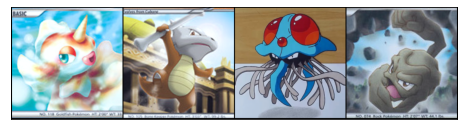

In [ ]:
show_batch(dataloader)

In [ ]:
# on split en train, val et test à partir de la liste complète
samples_train, samples_test = train_test_split(dataset_full.samples, test_size = 0.15, random_state = 42, shuffle = True)
samples_train, samples_val = train_test_split(samples_train, test_size=0.18, random_state = 42, shuffle = True)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 4753
Nombre d'images de val : 1044
Nombre d'images de test : 1023


In [ ]:
samples_train[0]

('/content/drive/My Drive/DLPokemon/pokemon_gen1_classification/Golbat/0fe1dcce097942aeb6df5d06dbe5f580.jpg',
 44)

In [ ]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
train_set = datasets.ImageFolder(image_directory, data_transforms)
train_set.samples = samples_train
train_set.imgs = samples_train

val_set = datasets.ImageFolder(image_directory, data_transforms)
val_set.samples = samples_val
val_set.imgs = samples_val

test_set = datasets.ImageFolder(image_directory, data_transforms)
test_set.samples = samples_test
test_set.imgs = samples_test

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 4753
    Root location: /content/drive/My Drive/DLPokemon/pokemon_gen1_classification
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [ ]:
# Détermination automatique du nombre de classes (nb_classes=6)
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 150 classes


In [ ]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # forcer en CPU s'il y a des problèmes de mémoire GPU (+ être patient...)
print(device)

cuda:0


## Training and evaluation functions

In [ ]:
# Define a function for training

def train(num_epochs, batch_size, criterion, optimizer, model):

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size, shuffle=False)
    max_accuracy, count = 0, 5
    losses_train, losses_val = [], []

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        epoch_average_loss = 0.0
        i = 0
        for (images, labels) in train_loader:
            images, labels = images.to(device), labels.to(device)
            y_pre = model(images) 
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
            i += 1
            if i % 50 == 0:
                print('Epoch {} batch {} [{}/{}] training loss: {}'
                        .format(epoch,i,i*batch_size, len(train_loader.dataset), loss.item()))

        print('Epoch [{}/{}], Training loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        losses_train.append(epoch_average_loss)

        # Validation
        model.eval()   
        val_average_loss = 0.0
        avg_accuracy = 0
        for (images, labels) in val_loader:
            with torch.no_grad():
                images, labels = images.to(device), labels.to(device)
                y_pre = model(images) 
                loss = criterion(y_pre, labels)
                val_average_loss += loss.item() * batch_size / len(val_set)
                _, preds = torch.max(y_pre, 1)
                n_correct = torch.sum(preds == labels)
            avg_accuracy += n_correct
        avg_accuracy = float(avg_accuracy) / len(val_set)
        print('Epoch [{}/{}], Validation loss: {:.4f}'
                      .format(epoch+1, num_epochs, val_average_loss)) 
        print('Epoch [{}/{}], Accuracy: {:.4f}'
                      .format(epoch+1, num_epochs,  avg_accuracy)) 
        print("--- %s seconds ---" % (time.time() - start_time))  
        losses_val.append(val_average_loss)

        # Early stopping
        if avg_accuracy > max_accuracy:
            torch.save(model, 'model_state.pth')
            max_accuracy = avg_accuracy
            count = 0
        else:
            count += 1
            if count >= 5:
                break
        
    return losses_train, losses_val

In [ ]:
# on définit une fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    i = 0
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
    for data in loader:
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        i += 1
    return avg_loss / len(loader), float(avg_accuracy) / len(dataset)

## CNN from Scratch

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            # Size 128@222x222
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 128@111x111
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            # Size 128@55x55
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 128@27x27
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            # Size 64@13x13
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 64@6x6
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2304, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 150)
        )

    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
class MyModel1(nn.Module):
    
    def __init__(self):
        super(MyModel1, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 32@112x112
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   
            # Size 32@56x56         
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 64@28x28  
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            # Size 64@14x14  
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Size 64@7x7 

        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*7*7, 1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 150)
        )

    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Create the model: 
model = MyModel1()
# model = torch.load("/content/drive/My Drive/DLPokemon/model_state.pth")
model.to(device)

# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

images.shape = torch.Size([8, 3, 224, 224]) \\
labels.shape = torch.Size([8])

In [ ]:
model = train(num_epochs, batch_size, criterion, optimizer, model)  # Batch size = 20

In [ ]:
torch.save(model, "/content/drive/My Drive/DLPokemon/model_state.pth")

In [ ]:
model = torch.load('model_state.pth')

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

15800758

In [ ]:
evaluate(model, train_set)

(0.05226381209986784, 0.986955606985062)

In [ ]:
evaluate(model, val_set)

(3.0163456002871194, 0.5766283524904214)

In [ ]:
evaluate(model, test_set)

(2.875489665195346, 0.5786901270772239)

## Transfer learning ResNet

In [ ]:
# Récupérer un réseau pré-entraîné (resnet-18)
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.resnet18(pretrained=True)
# print(my_net)

Récupération du ResNet-18 pré-entraîné...


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, my_net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

76950

In [ ]:
for param in my_net.parameters():
    param.requires_grad = False

my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)

In [ ]:
my_net.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible
my_net.train(True) # pas indispensable ici, mais bonne pratique de façon générale
                   # permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
                   
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(my_net.fc.parameters(), lr=0.001)

In [ ]:
train_error = train(num_epochs, batch_size, criterion, optimizer, my_net)

Epoch 0 batch 50 [1000/4753] training loss: 4.550421237945557
Epoch 0 batch 100 [2000/4753] training loss: 3.905444383621216
Epoch 0 batch 150 [3000/4753] training loss: 3.1847429275512695
Epoch 0 batch 200 [4000/4753] training loss: 2.908492088317871
Epoch [1/100], Training loss: 3.9063
Epoch [1/100], Validation loss: 2.6039
Epoch [1/100], Accuracy: 0.5144
--- 2334.0910181999207 seconds ---
Epoch 1 batch 50 [1000/4753] training loss: 2.2515034675598145
Epoch 1 batch 100 [2000/4753] training loss: 1.7026660442352295
Epoch 1 batch 150 [3000/4753] training loss: 1.7148969173431396
Epoch 1 batch 200 [4000/4753] training loss: 1.3141103982925415
Epoch [2/100], Training loss: 1.8180
Epoch [2/100], Validation loss: 1.6379
Epoch [2/100], Accuracy: 0.6877
--- 59.996819734573364 seconds ---
Epoch 2 batch 50 [1000/4753] training loss: 1.2608635425567627
Epoch 2 batch 100 [2000/4753] training loss: 0.8216322660446167
Epoch 2 batch 150 [3000/4753] training loss: 0.9664171934127808
Epoch 2 batch 20

In [ ]:
model = torch.load('model_state.pth')

In [ ]:
evaluate(model, train_set)

(0.0668693391649965, 0.9962129181569535)

In [ ]:
evaluate(model, val_set)

(0.7731680646538734, 0.8026819923371648)

In [ ]:
evaluate(model, test_set)

(0.7290028384886682, 0.7956989247311828)

## Transfer learning MobileNet

In [ ]:
# Récupérer un réseau pré-entraîné (resnet-18)
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.mobilenet_v2(pretrained=True)
# print(my_net)

Récupération du ResNet-18 pré-entraîné...


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, my_net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

192150

In [ ]:
for param in my_net.parameters():
    param.requires_grad = False

my_net.classifier[1] = nn.Linear(in_features=my_net.classifier[1].in_features, out_features=nb_classes, bias=True)

In [ ]:
my_net.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible
my_net.train(True) # pas indispensable ici, mais bonne pratique de façon générale
                   # permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
                   
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(my_net.classifier[1].parameters(), lr=0.001)

In [ ]:
train_error = train(num_epochs, batch_size, criterion, optimizer, my_net)

Epoch 0 batch 50 [1000/4753] training loss: 4.173005104064941
Epoch 0 batch 100 [2000/4753] training loss: 3.537414073944092
Epoch 0 batch 150 [3000/4753] training loss: 3.058605670928955
Epoch 0 batch 200 [4000/4753] training loss: 2.0650594234466553
Epoch [1/100], Training loss: 3.5574
Epoch [1/100], Validation loss: 2.0858
Epoch [1/100], Accuracy: 0.6102
--- 58.58812665939331 seconds ---
Epoch 1 batch 50 [1000/4753] training loss: 1.5401175022125244
Epoch 1 batch 100 [2000/4753] training loss: 1.1376965045928955
Epoch 1 batch 150 [3000/4753] training loss: 1.4100663661956787
Epoch 1 batch 200 [4000/4753] training loss: 1.5011327266693115
Epoch [2/100], Training loss: 1.3930
Epoch [2/100], Validation loss: 1.3348
Epoch [2/100], Accuracy: 0.7347
--- 58.817328691482544 seconds ---
Epoch 2 batch 50 [1000/4753] training loss: 0.634934663772583
Epoch 2 batch 100 [2000/4753] training loss: 1.155932903289795
Epoch 2 batch 150 [3000/4753] training loss: 0.7410331964492798
Epoch 2 batch 200 [

In [ ]:
model = torch.load('model_state.pth')

In [ ]:
evaluate(model, train_set)

(0.0658824874741344, 0.993477803492531)

In [ ]:
evaluate(model, val_set)

(0.8306723869208134, 0.7988505747126436)

In [ ]:
evaluate(model, test_set)

(0.7475728788413107, 0.804496578690127)

## Fine-tuning MobileNet

In [ ]:
# on réinitialise MobileNet
my_net_ft = models.mobilenet_v2(pretrained=True)
my_net_ft.classifier[1] = nn.Linear(in_features=my_net_ft.classifier[1].in_features, out_features=nb_classes, bias=True)

In [ ]:
list_of_layers_to_finetune=['classifier.1.weight','features.18.0.weight', 'features.18.1.weight', 'features.18.1.bias']
params_to_update=[]
for name,param in my_net_ft.named_parameters():
    if name in list_of_layers_to_finetune:
        print("fine tune ",name)
        params_to_update.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

fine tune  features.18.0.weight
fine tune  features.18.1.weight
fine tune  features.18.1.bias
fine tune  classifier.1.weight


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, my_net_ft.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

604160

In [ ]:
my_net_ft.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible
my_net_ft.train(True) # pas indispensable ici, mais bonne pratique de façon générale
                   # permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
                   
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
losses_train, losses_val = train(num_epochs, batch_size, criterion, optimizer, my_net_ft)

Epoch 0 batch 50 [1000/4753] training loss: 3.6984455585479736
Epoch 0 batch 100 [2000/4753] training loss: 2.611694097518921
Epoch 0 batch 150 [3000/4753] training loss: 2.3475072383880615
Epoch 0 batch 200 [4000/4753] training loss: 0.9974562525749207
Epoch [1/100], Training loss: 2.7270
Epoch [1/100], Validation loss: 1.0902
Epoch [1/100], Accuracy: 0.7605
--- 1519.8375976085663 seconds ---
Epoch 1 batch 50 [1000/4753] training loss: 0.6004033088684082
Epoch 1 batch 100 [2000/4753] training loss: 0.739642858505249
Epoch 1 batch 150 [3000/4753] training loss: 0.7012659907341003
Epoch 1 batch 200 [4000/4753] training loss: 1.2968580722808838
Epoch [2/100], Training loss: 0.6733
Epoch [2/100], Validation loss: 0.8427
Epoch [2/100], Accuracy: 0.7759
--- 59.971896171569824 seconds ---
Epoch 2 batch 50 [1000/4753] training loss: 0.2079099416732788
Epoch 2 batch 100 [2000/4753] training loss: 0.41096583008766174
Epoch 2 batch 150 [3000/4753] training loss: 0.2465916872024536
Epoch 2 batch 

In [ ]:
model = torch.load('model_state.pth')

In [ ]:
evaluate(model, train_set)

(0.029258133726784, 0.9951609509783295)

In [ ]:
evaluate(model, val_set)

(0.7651646954543663, 0.814176245210728)

In [ ]:
evaluate(model, test_set)

(0.6231438789982349, 0.8289345063538612)

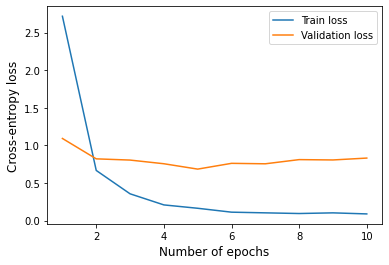

In [ ]:
x = [i for i in range(1, len(losses_train)+1)]
plt.plot(x, losses_train, label="Train loss")
plt.plot(x, losses_val, label="Validation loss")
plt.xlabel("Number of epochs", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.legend()
plt.show()

## Data augmentation

In [ ]:
# Normalisation des images pour les modèles pré-entraînés PyTorch
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# on lit une première fois les images du dataset
image_directory = "/content/drive/My Drive/DLPokemon/pokemon_gen1_classification"
dataset_full = datasets.ImageFolder(image_directory, data_transforms)

In [ ]:
dataset_full

Dataset ImageFolder
    Number of datapoints: 6820
    Root location: /content/drive/My Drive/DLPokemon/pokemon_gen1_classification
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [ ]:
# on split en train, val et test à partir de la liste complète
samples_train, samples_test = train_test_split(dataset_full.samples, test_size = 0.15, random_state = 42, shuffle = True)
samples_train, samples_val = train_test_split(samples_train, test_size=0.18, random_state = 42, shuffle = True)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 4753
Nombre d'images de val : 1044
Nombre d'images de test : 1023


In [ ]:
data_transforms_2 = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_transforms_3 = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_transforms_4 = transforms.Compose([
    transforms.Resize([224, 224]),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
train_set_1 = datasets.ImageFolder(image_directory, data_transforms)
train_set_1.samples = samples_train
train_set_1.imgs = samples_train

train_set_2 = datasets.ImageFolder(image_directory, data_transforms_2)
train_set_2.samples = samples_train
train_set_2.imgs = samples_train

train_set_3 = datasets.ImageFolder(image_directory, data_transforms_3)
train_set_3.samples = samples_train
train_set_3.imgs = samples_train

train_set_4 = datasets.ImageFolder(image_directory, data_transforms_4)
train_set_4.samples = samples_train
train_set_4.imgs = samples_train

# Combine the datasets
dataset_list = [train_set_1, train_set_2, train_set_3, train_set_4]
train_set = ConcatDataset(dataset_list)

In [ ]:
len(train_set)

19012

In [ ]:
val_set = datasets.ImageFolder(image_directory, data_transforms)
val_set.samples = samples_val
val_set.imgs = samples_val

test_set = datasets.ImageFolder(image_directory, data_transforms)
test_set.samples = samples_test
test_set.imgs = samples_test

In [ ]:
val_set

Dataset ImageFolder
    Number of datapoints: 1044
    Root location: /content/drive/My Drive/DLPokemon/pokemon_gen1_classification
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [ ]:
test_set

Dataset ImageFolder
    Number of datapoints: 1023
    Root location: /content/drive/My Drive/DLPokemon/pokemon_gen1_classification
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [ ]:
# Détermination automatique du nombre de classes (nb_classes=6)
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 150 classes


In [ ]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # forcer en CPU s'il y a des problèmes de mémoire GPU (+ être patient...)
print(device)

cuda:0


In [ ]:
# on réinitialise MobileNet
my_net_ft = models.mobilenet_v2(pretrained=True)
my_net_ft.classifier[1] = nn.Linear(in_features=my_net_ft.classifier[1].in_features, out_features=nb_classes, bias=True)

In [ ]:
list_of_layers_to_finetune=['classifier.1.weight','features.18.0.weight', 'features.18.1.weight', 'features.18.1.bias']
params_to_update=[]
for name,param in my_net_ft.named_parameters():
    if name in list_of_layers_to_finetune:
        print("fine tune ",name)
        params_to_update.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

fine tune  features.18.0.weight
fine tune  features.18.1.weight
fine tune  features.18.1.bias
fine tune  classifier.1.weight


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, my_net_ft.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

604160

In [ ]:
my_net_ft.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible
my_net_ft.train(True) # pas indispensable ici, mais bonne pratique de façon générale
                   # permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
                   
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(params_to_update, lr=0.0005)

In [ ]:
losses_train, losses_val = train(num_epochs, batch_size, criterion, optimizer, my_net_ft)

Epoch 0 batch 100 [2000/19012] training loss: 3.374746322631836
Epoch 0 batch 200 [4000/19012] training loss: 2.730818033218384
Epoch 0 batch 300 [6000/19012] training loss: 1.2592657804489136
Epoch 0 batch 400 [8000/19012] training loss: 1.0131670236587524
Epoch 0 batch 500 [10000/19012] training loss: 0.8126136660575867
Epoch 0 batch 600 [12000/19012] training loss: 0.6579079627990723
Epoch 0 batch 700 [14000/19012] training loss: 0.7724133729934692
Epoch 0 batch 800 [16000/19012] training loss: 0.548621416091919
Epoch 0 batch 900 [18000/19012] training loss: 0.5717636942863464
Epoch [1/100], Training loss: 1.4466
Epoch [1/100], Validation loss: 0.7296
Epoch [1/100], Accuracy: 0.8295
--- 1087.9620006084442 seconds ---
Epoch 1 batch 100 [2000/19012] training loss: 0.3640047311782837
Epoch 1 batch 200 [4000/19012] training loss: 0.36582016944885254
Epoch 1 batch 300 [6000/19012] training loss: 0.2370493859052658
Epoch 1 batch 400 [8000/19012] training loss: 0.2067059725522995
Epoch 1 b

In [ ]:
model = torch.load('model_state.pth')

In [ ]:
evaluate(model, train_set)

(0.026271581548821775, 0.9957921312855039)

In [ ]:
evaluate(model, val_set)

(0.6295491274107586, 0.8457854406130269)

In [ ]:
evaluate(model, test_set)

(0.5296303532086313, 0.8435972629521017)

## Interpretation

In [ ]:
model = torch.load("ModelI.pth")

In [ ]:
evaluate(model, test_set)

(0.5897693313891068, 0.8504398826979472)

In [ ]:
train_labels = np.array(train_set.samples)[:,1].astype(int)
print("Len train: ", len(train_labels))

repart_train = [0]*150
for i in train_labels:
    repart_train[i] += 1
print("Least present element: ", np.min(repart_train))


Len train:  4753
Least present element:  14


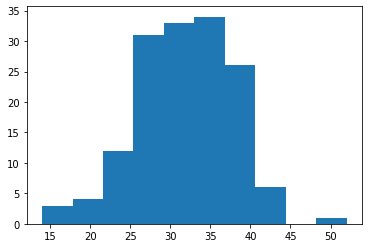

In [ ]:
plt.hist(repart_train, bins=10)
plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2000, shuffle=False)
for data in test_loader:
    with torch.no_grad():
        inputs, _ = data
        inputs = inputs.to(device)
        test_predictions = model(inputs)
        _, preds = torch.max(test_predictions, 1)

test_labels = np.array(test_set.samples)[:,1].astype(int)

In [ ]:
repart_acc = [0]*150
repart_num = [0]*150
n = len(test_labels)
for i in range(n):
    if test_labels[i] == preds[i]:
        repart_acc[test_labels[i]] += 1
    repart_num[test_labels[i]] += 1
for i in range(150):
    if repart_num[i] != 0:
        repart_acc[i] /= repart_num[i]
    else:
        repart_acc[i] = -1

In [ ]:
# Remove elements not in test set
for index, j in enumerate(repart_acc):  
    if j == -1:
        print(index)
        repart_acc.remove(j)
print(len(repart_acc))

22
27
148


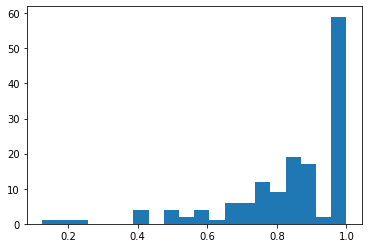

In [ ]:
plt.hist(repart_acc, bins=20)
plt.show()

In [ ]:
repart_train = [0]*150
for i in train_labels:
    repart_train[i] += 1
repart_train.pop(22)
repart_train.pop(26)
print(len(repart_train))
print(len(repart_acc))

148
148


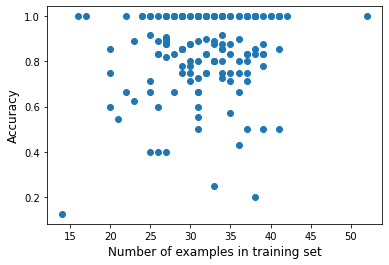

In [ ]:
plt.scatter(repart_train, repart_acc)
plt.xlabel("Number of examples in training set", size=12)
plt.ylabel("Accuracy", size=12)
plt.show()